<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2024年1月14日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.5.0-14-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.11.0
- python：3.10.13
- torch：2.1.1

In [1]:
import torch
from torch import nn
import numpy as np

from dataset import *
from utils import *

# 3-GRU

采用手动方式以及调用接口方式实现GRU，并在至少一种数据集上进行实验。

## 1. 手动实现GRU

In [2]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(h)
        return torch.stack(y_list, dim=1), h

Epoch [10/80], Train Loss: 0.0024, Train RMSE: 13.8044, Val Loss: 0.0002, Val RMSE: 3.982718, Time Use: 0.159s
Epoch [20/80], Train Loss: 0.0014, Train RMSE: 10.5428, Val Loss: 0.0002, Val RMSE: 3.570623, Time Use: 0.192s
Epoch [30/80], Train Loss: 0.0013, Train RMSE: 10.2883, Val Loss: 0.0002, Val RMSE: 3.488034, Time Use: 0.148s
Epoch [40/80], Train Loss: 0.0011, Train RMSE: 9.1993, Val Loss: 0.0001, Val RMSE: 3.298614, Time Use: 0.159s
Epoch [50/80], Train Loss: 0.0010, Train RMSE: 8.8358, Val Loss: 0.0001, Val RMSE: 3.193401, Time Use: 0.182s
Epoch [60/80], Train Loss: 0.0009, Train RMSE: 8.6454, Val Loss: 0.0001, Val RMSE: 3.480243, Time Use: 0.205s
Epoch [70/80], Train Loss: 0.0009, Train RMSE: 8.5091, Val Loss: 0.0001, Val RMSE: 3.413039, Time Use: 0.208s
Epoch [80/80], Train Loss: 0.0008, Train RMSE: 8.1959, Val Loss: 0.0001, Val RMSE: 3.137612, Time Use: 0.176s
Final result: Get best validation rmse 2.8995 at epoch 72, Total time 13.85s
Test result: Test RMSE: 7.51043308455933

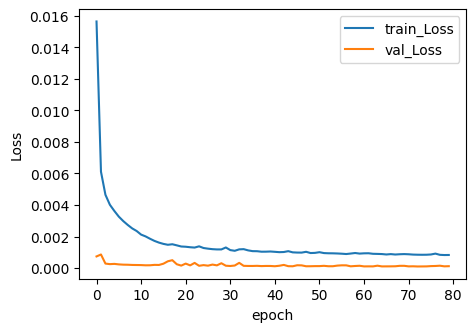

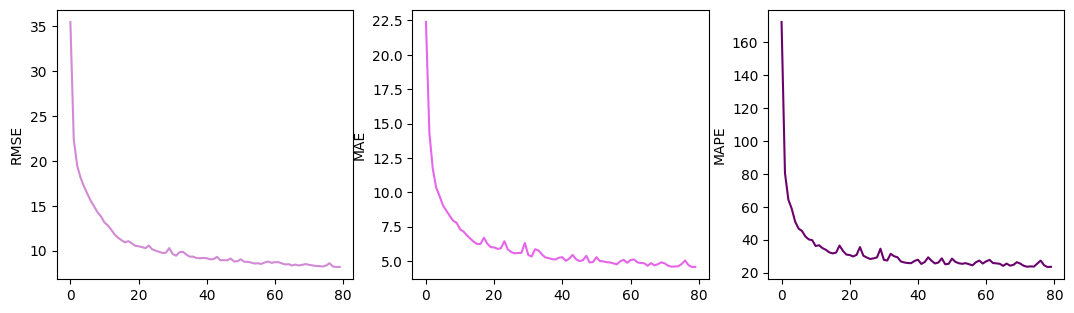

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.gru = My_GRU(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0031, Train RMSE: 62.8994, Val Loss: 0.0032, Val RMSE: 57.180920, Time Use: 0.276s
Epoch [20/80], Train Loss: 0.0026, Train RMSE: 57.8287, Val Loss: 0.0029, Val RMSE: 53.142134, Time Use: 0.373s
Epoch [30/80], Train Loss: 0.0024, Train RMSE: 55.5232, Val Loss: 0.0028, Val RMSE: 51.149546, Time Use: 0.303s
Epoch [40/80], Train Loss: 0.0023, Train RMSE: 54.3896, Val Loss: 0.0028, Val RMSE: 52.635308, Time Use: 0.382s
Epoch [50/80], Train Loss: 0.0023, Train RMSE: 54.3601, Val Loss: 0.0027, Val RMSE: 50.566234, Time Use: 0.326s
Epoch [60/80], Train Loss: 0.0022, Train RMSE: 53.3148, Val Loss: 0.0025, Val RMSE: 48.697364, Time Use: 0.380s
Epoch [70/80], Train Loss: 0.0022, Train RMSE: 53.6278, Val Loss: 0.0025, Val RMSE: 48.582108, Time Use: 0.357s
Epoch [80/80], Train Loss: 0.0022, Train RMSE: 53.1573, Val Loss: 0.0025, Val RMSE: 48.368787, Time Use: 0.367s
Final result: Get best validation rmse 47.9211 at epoch 78, Total time 26.44s
Test result: Test RMSE: 47

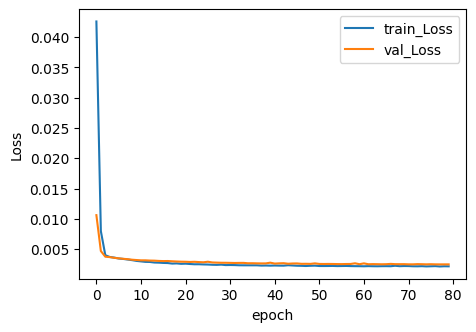

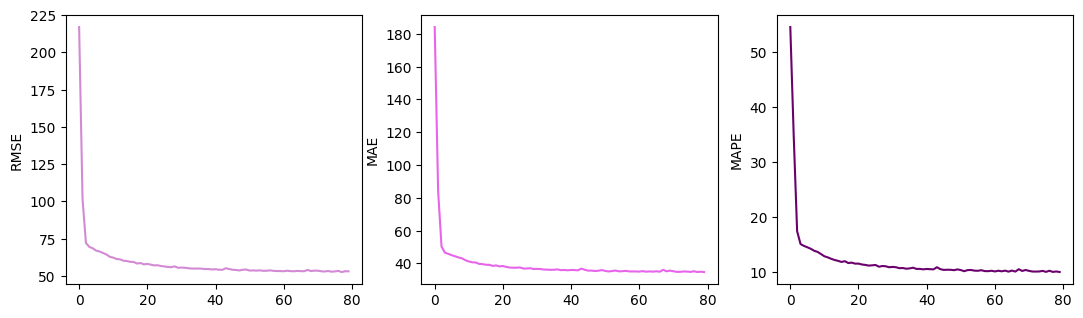

In [4]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

## 2. 调用`nn.GRU`接口

Epoch [10/80], Train Loss: 0.0029, Train RMSE: 15.3389, Val Loss: 0.0002, Val RMSE: 4.219435, Time Use: 0.079s
Epoch [20/80], Train Loss: 0.0017, Train RMSE: 11.7736, Val Loss: 0.0002, Val RMSE: 3.767341, Time Use: 0.080s
Epoch [30/80], Train Loss: 0.0014, Train RMSE: 10.7275, Val Loss: 0.0002, Val RMSE: 4.025482, Time Use: 0.080s
Epoch [40/80], Train Loss: 0.0012, Train RMSE: 9.6993, Val Loss: 0.0001, Val RMSE: 3.220265, Time Use: 0.079s
Epoch [50/80], Train Loss: 0.0011, Train RMSE: 9.4035, Val Loss: 0.0002, Val RMSE: 4.349239, Time Use: 0.080s
Epoch [60/80], Train Loss: 0.0010, Train RMSE: 8.8314, Val Loss: 0.0001, Val RMSE: 3.347545, Time Use: 0.081s
Epoch [70/80], Train Loss: 0.0009, Train RMSE: 8.5758, Val Loss: 0.0001, Val RMSE: 3.113162, Time Use: 0.080s
Epoch [80/80], Train Loss: 0.0009, Train RMSE: 8.4045, Val Loss: 0.0001, Val RMSE: 3.211182, Time Use: 0.080s
Final result: Get best validation rmse 2.8671 at epoch 77, Total time 6.41s
Test result: Test RMSE: 7.811078479398708

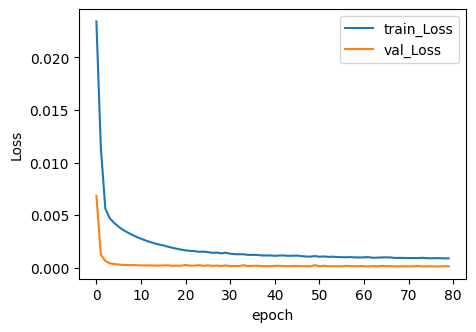

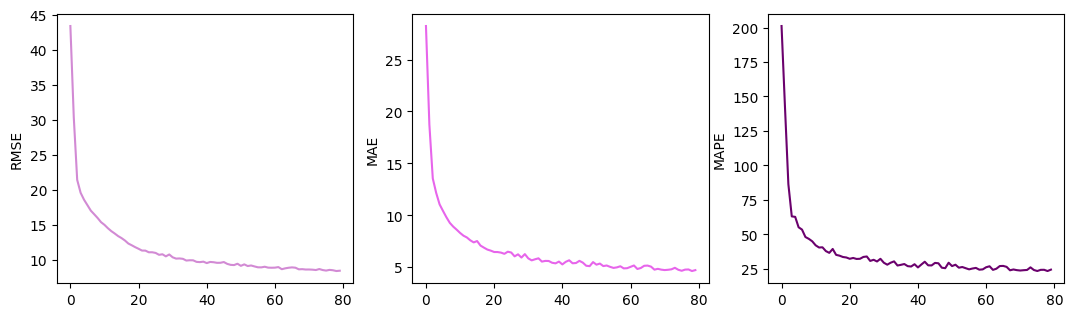

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0033, Train RMSE: 65.8079, Val Loss: 0.0033, Val RMSE: 59.303566, Time Use: 0.121s
Epoch [20/80], Train Loss: 0.0028, Train RMSE: 60.0128, Val Loss: 0.0031, Val RMSE: 56.236166, Time Use: 0.119s
Epoch [30/80], Train Loss: 0.0025, Train RMSE: 56.6970, Val Loss: 0.0028, Val RMSE: 52.275768, Time Use: 0.119s
Epoch [40/80], Train Loss: 0.0024, Train RMSE: 55.4753, Val Loss: 0.0027, Val RMSE: 50.919152, Time Use: 0.120s
Epoch [50/80], Train Loss: 0.0023, Train RMSE: 54.5480, Val Loss: 0.0026, Val RMSE: 49.779705, Time Use: 0.122s
Epoch [60/80], Train Loss: 0.0023, Train RMSE: 54.5517, Val Loss: 0.0026, Val RMSE: 49.571195, Time Use: 0.120s
Epoch [70/80], Train Loss: 0.0022, Train RMSE: 53.9536, Val Loss: 0.0025, Val RMSE: 48.883570, Time Use: 0.121s
Epoch [80/80], Train Loss: 0.0022, Train RMSE: 53.3551, Val Loss: 0.0025, Val RMSE: 49.012593, Time Use: 0.120s
Final result: Get best validation rmse 48.4206 at epoch 77, Total time 9.79s
Test result: Test RMSE: 48.

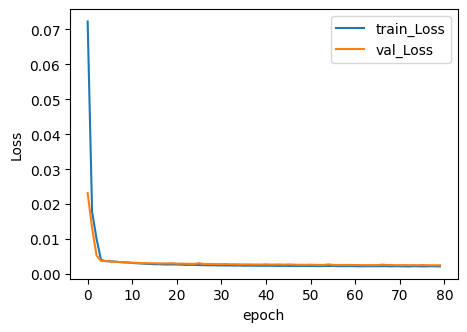

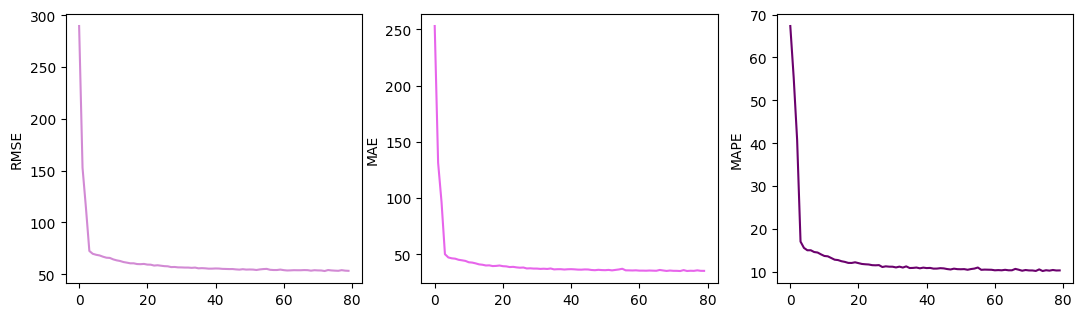

In [6]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

## 3. 三个神经网络的对比

从实际效果看，三个模型训练的最终正确率差不多。GRU和LSTM相对于RNN来说，收敛速度更快，说明模型能力更强。由于数据量不大，因此LSTM和GRU的显存使用量差别不大，但是在训练时长上来看，每个epoch中GRU的用时是LSTM的用时的约85%，是RNN的约25%，说明LSTM和GRU效率较普通RNN高。